# Test Pipeline Completa 6D Pose Estimation con PoseEstimator

Questo notebook permette di:
1. **Pipeline completa** YOLO detection → crop → 6D pose estimation

### Sezione da Eseguire sempre
Esegui sempre questa sezione per configurare l'ambiente. Poi scegli:
- **Test modello già trainato**

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from tqdm import tqdm

# Configura matplotlib per notebook
%matplotlib inline

# Aggiungi il path del progetto
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from dataset.custom_dataset import create_pose_dataloaders
from models.pose_estimator import PoseEstimator
from utils.losses import PoseLoss
from utils.metrics import load_all_models, load_models_info, compute_add_batch
from config import Config

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"🔢 Batch size: {Config.POSE_BATCH_SIZE}")

✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224
🔢 Batch size: 64


In [2]:
# Carica dataset con split ufficiale train/test
print("📦 Caricamento PoseDataset con split ufficiale...\n")

train_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.DATA_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE  # Adaptive: 0 on MPS, optimal on CUDA/CPU
)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento PoseDataset con split ufficiale...

🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 3759 train samples
🚀 Cached 13 gt.yml and 13 info.yml files
🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 21218 test samples
🚀 Cached 13 gt.yml and 13 info.yml files

📊 Pose DataLoaders created:
   Training samples: 3759
   Training batches: 59
   Test samples: 21218
   Test batches: 332
✅ Dataset caricato:
   Train batches: 59 (batch_size=64)
   Test batches: 332
   Train samples: ~3776
   Test samples: ~21248
   Crop margin: 15%
   Output size: 224x224
   Workers: 0 (adaptive per mps)


### Carica Modello Trained

Carica il checkpoint salvato e testa su sample del test set.

In [3]:
# Carica il modello trained
LOAD_EXPERIMENT = "pose_stable_train100"

checkpoint_dir = project_root / 'checkpoints' / 'pose' / LOAD_EXPERIMENT
checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'

# Fallback ad altri esperimenti
if not checkpoint_path.exists():
    LOAD_EXPERIMENT = "pose_stable_train70"
    checkpoint_dir = project_root / 'checkpoints' / 'pose' / LOAD_EXPERIMENT
    checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'
    print(f"⚠️  Fase 1 non trovata, carico esperimento: {LOAD_EXPERIMENT}\n")

# Fallback al vecchio path se non esiste
if not checkpoint_path.exists():
    checkpoint_path = project_root / 'checkpoints' / 'pose_best_quick.pth'
    print(f"⚠️  Nuovo path non trovato, uso vecchio checkpoint: {checkpoint_path.name}\n")

if checkpoint_path.exists():
    print(f"✅ Carico checkpoint: {checkpoint_path.relative_to(project_root)}\n")
    
    # Inizializza modello se non già fatto
    if 'model' not in locals():
        model = PoseEstimator(
            pretrained=True,
            dropout=Config.POSE_DROPOUT,
            freeze_backbone=False  # ✅ Coerente con Fase 1
        ).to(Config.DEVICE)
    
    # Carica weights
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"📊 Checkpoint info:")
    print(f"   Epoch: {checkpoint['epoch'] + 1}")
    print(f"   Loss: {checkpoint['loss']:.4f}")
    if 'loss_trans' in checkpoint:
        print(f"   Trans Loss: {checkpoint['loss_trans']:.4f}")
        print(f"   Rot Loss: {checkpoint['loss_rot']:.2f}")
    if 'config' in checkpoint:
        print(f"\n📋 Training config:")
        for key, value in checkpoint['config'].items():
            print(f"      {key}: {value}")
    print(f"\n   Device: {Config.DEVICE}")
    print(f"\n✅ Modello caricato e in modalità eval!")
    
else:
    print(f"❌ Checkpoint non trovato: {checkpoint_path}")
    print(f"   Path cercati:")
    print(f"   1. {checkpoint_dir / 'weights' / 'best.pt'}")
    print(f"   2. {project_root / 'checkpoints' / 'pose_best_quick.pth'}")
    print(f"\n   Esegui prima il training Fase 1 (cella 9)")
    print(f"   Oppure cambia LOAD_EXPERIMENT con un esperimento esistente")

✅ Carico checkpoint: checkpoints/pose/pose_stable_train100/weights/best.pt



/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: ResNet-50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
📊 Checkpoint info:
   Epoch: 100
   Loss: 17.1820
   Trans Loss: 4.8458
   Rot Loss: 0.25

📋 Training config:
      phase: Phase 1 - Optimized
      epochs: 100
      warmup_epochs: 5
      lr_backbone: 5e-06
      lr_head: 0.0001
      batch_size: 64
      accumulation_steps: 2
      effective_batch_size: 128
      use_amp: False
      lambda_trans: 1.0
      lambda_rot: 50.0
      dropout: 0.5
      freeze_backbone: False
      scheduler: ReduceLROnPlateau
      device: mps
      image_size: 224
      crop_margin: 0.15

   Device: mps

✅ Modello caricato e in modalità eval!


### Test su Sample del Test Set

Visualizza predizioni vs ground truth su batch del test set.

🔍 Test su sample del test set...

🎲 Batch casuale selezionato: 292/332



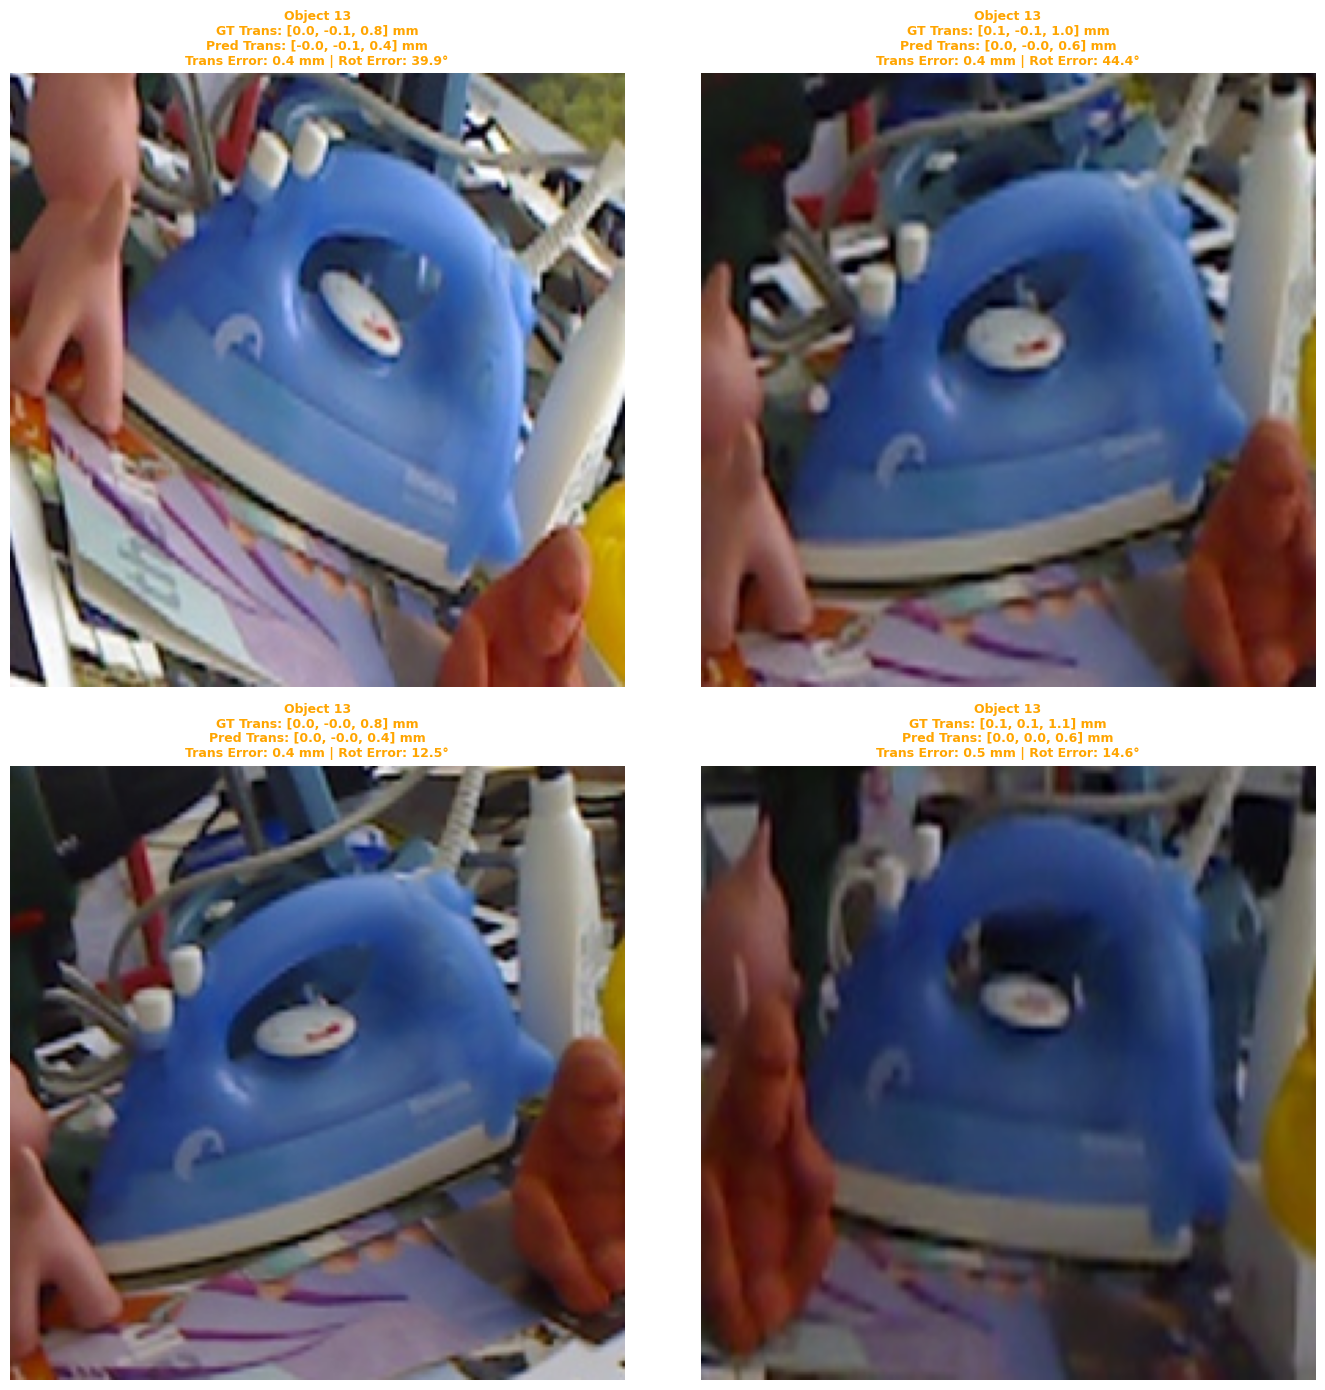

✅ Test completato su 64 sample

📊 Errori medi sul batch:
   Translation error: 0.32 ± 0.10 mm
   Rotation error: 28.19 ± 18.20°

💡 Interpretazione colori:
   🟢 Verde: Trans < 50mm e Rot < 10°
   🟠 Arancione: 50mm < Trans < 100mm
   🔴 Rosso: Trans > 100mm o Rot > 10°


In [4]:
import random

# Test su batch del test set
if 'model' in locals() and checkpoint_path.exists():
    print("🔍 Test su sample del test set...\n")
    
    # Prendi un batch casuale
    random_batch_idx = random.randint(0, len(test_loader) - 1)
    for idx, batch in enumerate(test_loader):
        if idx == random_batch_idx:
            test_batch = batch
            break
    
    print(f"🎲 Batch casuale selezionato: {random_batch_idx + 1}/{len(test_loader)}\n")
    images = test_batch['rgb_crop'].to(Config.DEVICE)
    gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
    gt_translations = test_batch['translation'].to(Config.DEVICE)
    obj_ids = test_batch['obj_id']
    
    # Predizione
    with torch.no_grad():
        pred_quaternions, pred_translations = model(images)
    
    # Calcola errori
    trans_errors = torch.norm(pred_translations - gt_translations, dim=1).cpu().numpy()
    
    # Calcola rotation error (geodesic distance)
    dot_products = torch.sum(pred_quaternions * gt_quaternions, dim=1)
    dot_products = torch.clamp(torch.abs(dot_products), 0, 1)
    rot_errors = 2 * torch.acos(dot_products) * 180 / np.pi  # In gradi
    rot_errors = rot_errors.cpu().numpy()
    
    # Visualizza 4 sample
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    for i in range(min(4, len(images))):
        # Denormalizza immagine
        img = images[i].permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # Ground truth e prediction
        gt_q = gt_quaternions[i].cpu().numpy()
        gt_t = gt_translations[i].cpu().numpy()
        pred_q = pred_quaternions[i].cpu().numpy()
        pred_t = pred_translations[i].cpu().numpy()
        obj_id = obj_ids[i].item()
        
        axes[i].imshow(img)
        title = (
            f"Object {obj_id:02d}\n"
            f"GT Trans: [{gt_t[0]:.1f}, {gt_t[1]:.1f}, {gt_t[2]:.1f}] mm\n"
            f"Pred Trans: [{pred_t[0]:.1f}, {pred_t[1]:.1f}, {pred_t[2]:.1f}] mm\n"
            f"Trans Error: {trans_errors[i]:.1f} mm | Rot Error: {rot_errors[i]:.1f}°"
        )
        
        # Colora in base all'errore
        color = 'green' if trans_errors[i] < 50 and rot_errors[i] < 10 else 'orange' if trans_errors[i] < 100 else 'red'
        axes[i].set_title(title, fontsize=9, color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Test completato su {len(images)} sample")
    print(f"\n📊 Errori medi sul batch:")
    print(f"   Translation error: {trans_errors.mean():.2f} ± {trans_errors.std():.2f} mm")
    print(f"   Rotation error: {rot_errors.mean():.2f} ± {rot_errors.std():.2f}°")
    print(f"\n💡 Interpretazione colori:")
    print(f"   🟢 Verde: Trans < 50mm e Rot < 10°")
    print(f"   🟠 Arancione: 50mm < Trans < 100mm")
    print(f"   🔴 Rosso: Trans > 100mm o Rot > 10°")
    
else:
    print("❌ Carica prima il modello (cella precedente)")

### Valutazione Completa con ADD Metric

Valutazione su tutto il test set con metrica ADD (Average Distance of Model Points).
ADD < 10% del diametro dell'oggetto è considerato corretto.

In [5]:
# Carica modelli 3D (.ply) e models_info
print("📦 Caricamento modelli 3D per ADD metric...\n")

models_dict = load_all_models(Config.MODELS_PATH)
models_info = load_models_info(Config.MODELS_INFO_PATH)

print(f"✅ Caricati {len(models_dict)} modelli 3D:")
for obj_id, points in models_dict.items():
    diameter = models_info[obj_id]['diameter']
    print(f"   Object {obj_id:02d}: {len(points):,} punti, diametro {diameter:.1f} mm")

print(f"\n📊 ADD threshold: {Config.ADD_THRESHOLD * 100:.0f}% del diametro")
print(f"   Esempio: se diametro = 100mm, threshold = 10mm")

📦 Caricamento modelli 3D per ADD metric...

✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 03: 40759 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 07: 16573 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points
✅ Caricati 15 modelli 3D:
   Object 01: 5,841 punti, diametro 102.1 mm
   Object 02: 38,325 punti, diametro 247.5 mm
   Object 03: 40,759 punti, diametro 167.4 mm
   Object 04: 18,995 punti, diametro 172.5 mm
   Object 05: 22,831 punti, diametro 201.4 mm
   Object 06: 15,736 punti, diametro 154.5 mm
   Object 07: 16,573 punti, diametro 124.3 mm
   Object 08: 12,655 punti, diametro 261.5 mm
   Object 09: 7,912 punti, diametro 109.0 mm
   Object 10: 18,473 punti, diametro 164.

In [6]:
# Valutazione completa con ADD metric
if 'model' in locals() and checkpoint_path.exists() and 'models_dict' in locals():
    print("🔍 Valutazione completa su test set con ADD metric...\n")
    print(f"⏳ Questo richiederà alcuni minuti...\n")
    
    model.eval()
    
    # Dizionari per raccogliere risultati per oggetto
    per_object_adds = {obj_id: [] for obj_id in Config.LINEMOD_OBJECTS}
    per_object_correct = {obj_id: 0 for obj_id in Config.LINEMOD_OBJECTS}
    per_object_total = {obj_id: 0 for obj_id in Config.LINEMOD_OBJECTS}
    
    all_adds = []
    
    # ✅ VALUTAZIONE COMPLETA - rimosso MAX_SAMPLES limit
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move to device
            images = batch['rgb_crop'].to(Config.DEVICE)
            gt_quaternions = batch['quaternion'].to(Config.DEVICE)
            gt_translations = batch['translation'].to(Config.DEVICE)
            obj_ids = batch['obj_id'].cpu().numpy()
            
            # Predizione
            pred_quaternions, pred_translations = model(images)
            
            # ✅ VETTORIZZATO: Converti batch di quaternion in batch di rotation matrices (10x speedup!)
            from utils.transforms import quaternion_to_rotation_matrix_batch
            
            pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions).cpu().numpy()
            gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions).cpu().numpy()
            
            pred_t = pred_translations.cpu().numpy()
            gt_t = gt_translations.cpu().numpy()
            
            # Calcola ADD per ogni sample nel batch (ritorna un dizionario)
            result = compute_add_batch(
                pred_R, pred_t, gt_R, gt_t,
                obj_ids, models_dict, models_info,
                threshold=Config.ADD_THRESHOLD,
                symmetric_objects=Config.SYMMETRIC_OBJECTS
            )
            
            # Estrai i valori dal dizionario
            adds = result['add_values']
            corrects = result['is_correct']
            
            # Accumula risultati per oggetto
            for i, obj_id in enumerate(obj_ids):
                per_object_adds[obj_id].append(adds[i])
                per_object_total[obj_id] += 1
                if corrects[i]:
                    per_object_correct[obj_id] += 1
                all_adds.append(adds[i])
    
    # Calcola statistiche globali
    mean_add = np.mean(all_adds)
    median_add = np.median(all_adds)
    std_add = np.std(all_adds)
    total_correct = sum(per_object_correct.values())
    total_samples = sum(per_object_total.values())
    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0
    
    # Calcola accuracy per oggetto
    per_object_accuracy = {}
    for obj_id in Config.LINEMOD_OBJECTS:
        if per_object_total[obj_id] > 0:
            per_object_accuracy[obj_id] = per_object_correct[obj_id] / per_object_total[obj_id]
        else:
            per_object_accuracy[obj_id] = 0
    
    # Stampa risultati
    print(f"\n{'='*80}")
    print(f"📈 RISULTATI VALUTAZIONE - ADD METRIC @ {Config.ADD_THRESHOLD * 100:.0f}% THRESHOLD")
    print(f"{'='*80}\n")
    
    print(f"🎯 Metriche Globali:")
    print(f"   Mean ADD: {mean_add:.2f} mm")
    print(f"   Median ADD: {median_add:.2f} mm")
    print(f"   Std ADD: {std_add:.2f} mm")
    print(f"   Overall Accuracy: {overall_accuracy * 100:.2f}%")
    print(f"   Correct: {total_correct} / {total_samples}")
    
    print(f"\n📋 Accuracy per Oggetto:")
    print(f"   {'Obj ID':<8} {'Accuracy':<12} {'Correct/Total':<15} {'Mean ADD (mm)':<15}")
    print(f"   {'-'*60}")
    
    for obj_id in sorted(Config.LINEMOD_OBJECTS):
        if per_object_total[obj_id] > 0:
            acc = per_object_accuracy[obj_id]
            mean_obj_add = np.mean(per_object_adds[obj_id])
            print(f"   {obj_id:<8} {acc*100:>6.2f}%      {per_object_correct[obj_id]:>4}/{per_object_total[obj_id]:<8}  {mean_obj_add:>12.2f}")
    
    # Interpretazione
    print(f"\n💡 Interpretazione:")
    if overall_accuracy > 0.7:
        print(f"   ✅ Ottimo! Accuracy > 70% indica pose estimation accurate")
    elif overall_accuracy > 0.5:
        print(f"   ✓  Buono! Accuracy > 50% indica pose discrete")
    elif overall_accuracy > 0.3:
        print(f"   ⚠️  Discreto. Accuracy > 30% ma potrebbe migliorare con più training")
    else:
        print(f"   ❌ Basso. Considerare 50 epoche con backbone unfrozen")
    
    print(f"\n✅ Valutazione completata su TUTTO il test set!")
    print(f"   Metriche accurate basate su {total_samples} sample totali")
    
else:
    print("❌ Carica prima il modello e i modelli 3D (celle precedenti)")

🔍 Valutazione completa su test set con ADD metric...

⏳ Questo richiederà alcuni minuti...



Evaluating:   8%|▊         | 28/332 [00:29<07:59,  1.58s/it]

Evaluating:  43%|████▎     | 144/332 [03:42<05:10,  1.65s/it]

Evaluating:  45%|████▍     | 148/332 [03:49<05:14,  1.71s/it]

Evaluating: 100%|██████████| 332/332 [08:14<00:00,  1.49s/it]


📈 RISULTATI VALUTAZIONE - ADD METRIC @ 10% THRESHOLD

🎯 Metriche Globali:
   Mean ADD: 22.35 mm
   Median ADD: 17.39 mm
   Std ADD: 17.06 mm
   Overall Accuracy: 49.67%
   Correct: 10538 / 21218

📋 Accuracy per Oggetto:
   Obj ID   Accuracy     Correct/Total   Mean ADD (mm)  
   ------------------------------------------------------------
   1         43.85%       895/2041             13.39
   2         41.71%       430/1031             35.42
   4         35.00%       357/1020             27.41
   5         44.63%       911/2041             27.98
   6         57.09%      1148/2011             17.28
   8         97.30%      1985/2040             12.97
   9         29.12%       592/2033             19.03
   10        40.37%       832/2061             24.71
   11        59.26%      1066/1799             18.28
   12        32.85%       683/2079             25.11
   13        59.86%       586/979              29.14
   14        58.64%       611/1042             29.26
   15        42.46%   

📊 Visualizzazione risultati ADD metric



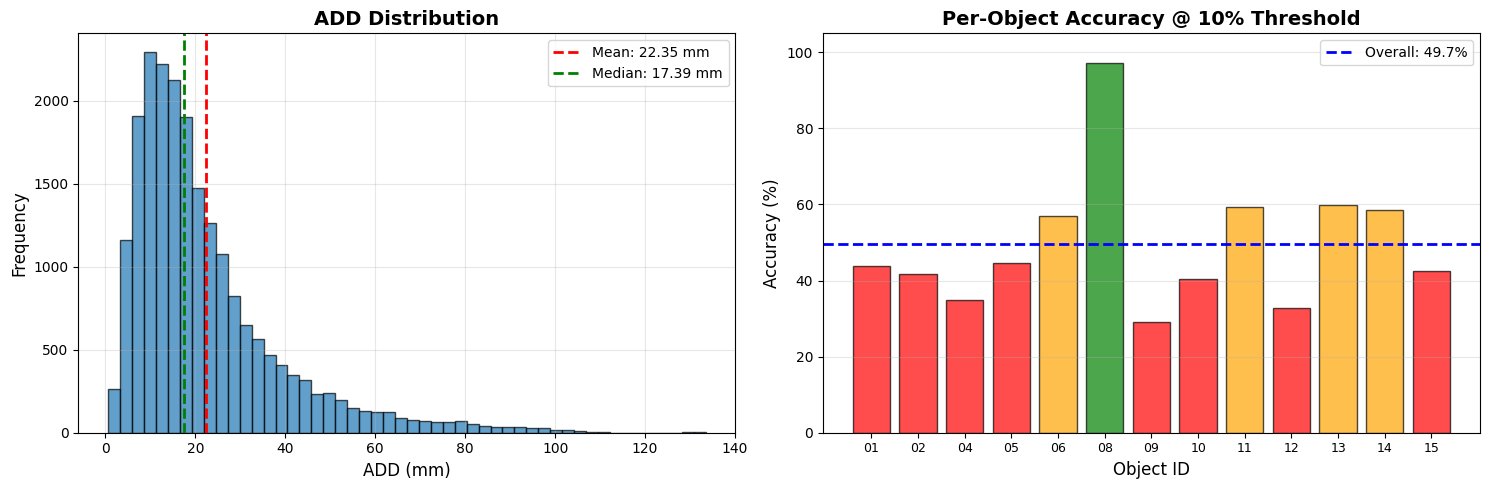

✅ Visualizzazione completata!

💡 Interpretazione colori (Accuracy bar chart):
   🟢 Verde: Accuracy > 70%
   🟠 Arancione: 50% < Accuracy < 70%
   🔴 Rosso: Accuracy < 50%


In [7]:
# Visualizza distribuzione ADD e accuracy per oggetto
if 'all_adds' in locals() and 'per_object_accuracy' in locals():
    print("📊 Visualizzazione risultati ADD metric\n")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # ADD distribution histogram
    axes[0].hist(all_adds, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(mean_add, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_add:.2f} mm')
    axes[0].axvline(median_add, color='green', linestyle='--', linewidth=2, label=f'Median: {median_add:.2f} mm')
    axes[0].set_xlabel('ADD (mm)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('ADD Distribution', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Per-object accuracy bar chart
    obj_ids = sorted(Config.LINEMOD_OBJECTS)
    accuracies = [per_object_accuracy[obj_id] * 100 for obj_id in obj_ids]
    colors = ['green' if acc > 70 else 'orange' if acc > 50 else 'red' for acc in accuracies]
    
    bars = axes[1].bar(range(len(obj_ids)), accuracies, color=colors, edgecolor='black', alpha=0.7)
    axes[1].axhline(overall_accuracy * 100, color='blue', linestyle='--', linewidth=2, label=f'Overall: {overall_accuracy*100:.1f}%')
    axes[1].set_xlabel('Object ID', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'Per-Object Accuracy @ {Config.ADD_THRESHOLD*100:.0f}% Threshold', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(obj_ids)))
    axes[1].set_xticklabels([f'{obj_id:02d}' for obj_id in obj_ids], fontsize=9)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim([0, 105])
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualizzazione completata!")
    print(f"\n💡 Interpretazione colori (Accuracy bar chart):")
    print(f"   🟢 Verde: Accuracy > 70%")
    print(f"   🟠 Arancione: 50% < Accuracy < 70%")
    print(f"   🔴 Rosso: Accuracy < 50%")
    
else:
    print("❌ Esegui prima la valutazione completa (cella precedente)")

---

### Pipeline Completa: YOLO Detection + Pose Estimation

Test della pipeline completa end-to-end:
1. YOLO11n fine-tuned rileva oggetti e bbox
2. Crop immagine attorno al bbox
3. PoseEstimator predice 6D pose (quaternion + translation)

🔗 Pipeline completa: YOLO Detection + Pose Estimation

📋 Modello PoseEstimator caricato:
   Esperimento: pose_stable_train100
   Checkpoint: checkpoints/pose/pose_stable_train100/weights/best.pt
   Device: mps

📦 Caricamento YOLO fine-tuned...
✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_head_only/weights/best.pt
✅ YOLO caricato: best.pt

🎲 Selezione immagine casuale dal dataset...

📷 Immagine selezionata:
   Path: data/15/rgb/0758.png
   Size: 640x480
   Totale immagini disponibili: 15800

🔍 Step 1: YOLO Detection...
   Rilevati 1 oggetti

✂️  Step 2: Crop e Pose Estimation per ogni oggetto...

   [1/1] phone (conf=0.58)
         Bbox: [274, 117, 398, 245]
         Quaternion: [-0.020, -0.368, -0.927, 0.072]
         Translation: [0.0, -0.1, 0.3] mm

📊 Step 3: Visualizzazione risultati...

💡 Corrispondenza:
   • [k] sull'immagine con YOLO = detection k-esima
   • [k] sul crop = stesso oggetto passato

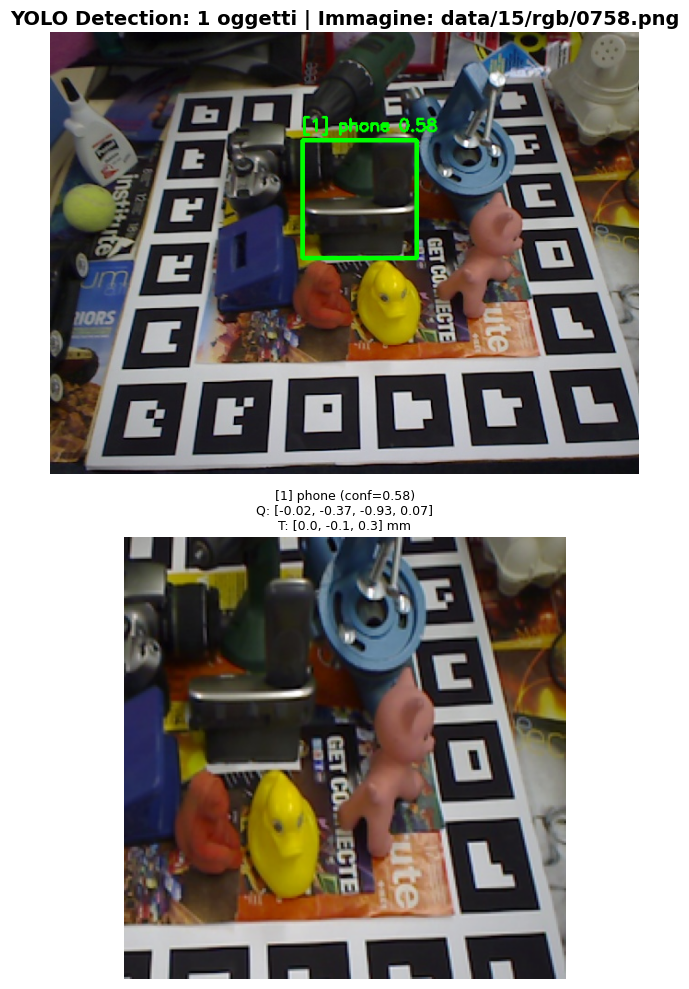

✅ Pipeline completata!
   1 oggetti rilevati e pose stimati
   Modello usato: pose_stable_train100

💡 Nota: I numeri [1], [2], ... indicano la stessa detection sia:
   • Nel bbox YOLO sull'immagine originale
   • Nel crop mostrato sotto con la posa stimata

🎲 Esegui di nuovo la cella per testare su un'altra immagine casuale!


In [11]:
# Pipeline completa: YOLO → Crop → Pose Estimation
from models.yolo_detector import YOLODetector
from utils.transforms import crop_image_from_bbox, get_pose_transforms
import random
import glob

# Carica YOLO fine-tuned
yolo_weights = project_root / 'checkpoints' / 'yolo' / 'yolo_head_only' / 'weights' / 'best.pt'

if yolo_weights.exists() and 'model' in locals() and checkpoint_path.exists():
    print("🔗 Pipeline completa: YOLO Detection + Pose Estimation\n")
    
    # ✅ VERIFICA: Assicurati che il modello caricato sia quello corretto
    print(f"📋 Modello PoseEstimator caricato:")
    print(f"   Esperimento: {LOAD_EXPERIMENT}")
    print(f"   Checkpoint: {checkpoint_path.relative_to(project_root)}")
    print(f"   Device: {Config.DEVICE}\n")
    
    # Carica YOLO
    print("📦 Caricamento YOLO fine-tuned...")
    yolo_detector = YOLODetector(
        model_name=str(yolo_weights),
        num_classes=Config.NUM_CLASSES
    )
    print(f"✅ YOLO caricato: {yolo_weights.name}\n")
    
    # ✅ SELEZIONE IMMAGINE CASUALE: Trova tutte le immagini disponibili
    print("🎲 Selezione immagine casuale dal dataset...\n")
    
    # Lista tutte le cartelle degli oggetti
    data_root = Config.DATA_ROOT / 'data'
    available_images = []
    
    for obj_folder in sorted(data_root.iterdir()):
        if obj_folder.is_dir() and obj_folder.name.isdigit():
            rgb_folder = obj_folder / 'rgb'
            if rgb_folder.exists():
                # Trova tutte le immagini PNG
                images_in_folder = list(rgb_folder.glob('*.png'))
                available_images.extend(images_in_folder)
    
    if not available_images:
        print("❌ Nessuna immagine trovata nel dataset")
    else:
        # Seleziona un'immagine casuale
        test_img_path = random.choice(available_images)
        test_image = np.array(Image.open(test_img_path).convert('RGB'))
        
        # Estrai informazioni dal path
        obj_id = test_img_path.parent.parent.name
        img_name = test_img_path.name
        
        print(f"📷 Immagine selezionata:")
        print(f"   Path: data/{obj_id}/rgb/{img_name}")
        print(f"   Size: {test_image.shape[1]}x{test_image.shape[0]}")
        print(f"   Totale immagini disponibili: {len(available_images)}\n")
        
        # Step 1: YOLO detection
        print("🔍 Step 1: YOLO Detection...")
        detections = yolo_detector.detect_objects(test_image, conf_threshold=0.3)
        print(f"   Rilevati {len(detections)} oggetti\n")
        
        if len(detections) == 0:
            print("❌ Nessun oggetto rilevato. Prova con un'altra immagine o lower confidence threshold.")
            print("   💡 Esegui di nuovo la cella per selezionare un'altra immagine casuale")
        else:
            # Step 2: Crop e Pose Estimation per ogni detection
            print("✂️  Step 2: Crop e Pose Estimation per ogni oggetto...\n")
            
            pose_transforms = get_pose_transforms(train=False)
            results = []
            
            for idx, det in enumerate(detections):
                bbox = det['bbox']  # [x1, y1, x2, y2]
                obj_name = det['class_name']
                conf = det['confidence']
                
                print(f"   [{idx+1}/{len(detections)}] {obj_name} (conf={conf:.2f})")
                print(f"         Bbox: [{int(bbox[0])}, {int(bbox[1])}, {int(bbox[2])}, {int(bbox[3])}]")
                
                # Crop con margin (ritorna già PIL Image)
                cropped = crop_image_from_bbox(
                    test_image,
                    bbox,
                    margin=Config.POSE_CROP_MARGIN,
                    output_size=(Config.POSE_IMAGE_SIZE, Config.POSE_IMAGE_SIZE)
                )
                
                # Preprocessing (cropped è già PIL Image, no fromarray needed)
                cropped_tensor = pose_transforms(cropped)
                cropped_tensor = cropped_tensor.unsqueeze(0).to(Config.DEVICE)
                
                # Pose prediction con il modello caricato
                with torch.no_grad():
                    pred_quat, pred_trans = model(cropped_tensor)
                
                pred_quat = pred_quat[0].cpu().numpy()
                pred_trans = pred_trans[0].cpu().numpy()
                
                results.append({
                    'bbox': bbox,
                    'class_name': obj_name,
                    'confidence': conf,
                    'quaternion': pred_quat,
                    'translation': pred_trans,
                    'cropped': np.array(cropped)  # crop “pulito”, solo per visualizzazione
                })
                
                print(f"         Quaternion: [{pred_quat[0]:.3f}, {pred_quat[1]:.3f}, {pred_quat[2]:.3f}, {pred_quat[3]:.3f}]")
                print(f"         Translation: [{pred_trans[0]:.1f}, {pred_trans[1]:.1f}, {pred_trans[2]:.1f}] mm\n")
            
            # Step 3: Visualizzazione
            print(f"📊 Step 3: Visualizzazione risultati...\n")
            print("💡 Corrispondenza:")
            print("   • [k] sull'immagine con YOLO = detection k-esima")
            print("   • [k] sul crop = stesso oggetto passato al PoseEstimator\n")
            
            n_detections = len(results)
            n_cols = min(3, n_detections)
            n_rows = (n_detections + n_cols - 1) // n_cols
            
            # Create figure with GridSpec for custom layout
            fig = plt.figure(figsize=(15, 5 * (n_rows + 1)))
            
            # ✅ Draw bounding boxes sull'immagine originale
            img_with_bbox = test_image.copy()
            try:
                import cv2
                colors_bgr = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
                for idx, res in enumerate(results):
                    x1, y1, x2, y2 = res['bbox']
                    color = colors_bgr[idx % len(colors_bgr)]
                    cv2.rectangle(img_with_bbox, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
                    # Label con numero per tracciare corrispondenza
                    label = f"[{idx+1}] {res['class_name']} {res['confidence']:.2f}"
                    cv2.putText(
                        img_with_bbox,
                        label,
                        (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        color,
                        2
                    )
            except ImportError:
                print("⚠️  OpenCV non installato. Visualizzazione senza bounding boxes...")
                print("   Per installarla: pip install opencv-python\n")
            
            # Immagine originale con bbox (riga in alto, tutte le colonne)
            ax_orig = plt.subplot2grid((n_rows + 1, n_cols), (0, 0), colspan=n_cols)
            ax_orig.imshow(img_with_bbox)
            ax_orig.set_title(
                f"YOLO Detection: {n_detections} oggetti | Immagine: data/{obj_id}/rgb/{img_name}", 
                fontsize=14, fontweight='bold'
            )
            ax_orig.axis('off')
            
            # Crops con pose (righe sotto) - Numerati per corrispondenza
            for idx, res in enumerate(results):
                row = (idx // n_cols) + 1
                col = idx % n_cols
                ax = plt.subplot2grid((n_rows + 1, n_cols), (row, col))
                ax.imshow(res['cropped'])
                title = (
                    f"[{idx+1}] {res['class_name']} (conf={res['confidence']:.2f})\n"
                    f"Q: [{res['quaternion'][0]:.2f}, {res['quaternion'][1]:.2f}, "
                    f"{res['quaternion'][2]:.2f}, {res['quaternion'][3]:.2f}]\n"
                    f"T: [{res['translation'][0]:.1f}, {res['translation'][1]:.1f}, {res['translation'][2]:.1f}] mm"
                )
                ax.set_title(title, fontsize=9)
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"✅ Pipeline completata!")
            print(f"   {n_detections} oggetti rilevati e pose stimati")
            print(f"   Modello usato: {LOAD_EXPERIMENT}")
            print(f"\n💡 Nota: I numeri [1], [2], ... indicano la stessa detection sia:")
            print(f"   • Nel bbox YOLO sull'immagine originale")
            print(f"   • Nel crop mostrato sotto con la posa stimata")
            print(f"\n🎲 Esegui di nuovo la cella per testare su un'altra immagine casuale!")

else:
    if not yolo_weights.exists():
        print(f"❌ YOLO weights non trovati: {yolo_weights}")
        print(f"   Allena prima YOLO (vedi test_yolo2_finetuning.ipynb)")
    else:
        print("❌ Carica prima il PoseEstimator (celle precedenti)")
